# Time-Series MIA Example 
Base of example. Use and build upon this notebook during development.

In [1]:
import os
import sys
import yaml
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import ECGDataset, preprocess_ECG_dataset, get_ECG_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.TimesNet import TimesNet
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.TFT import TFT

In [2]:
# Define constants
lookback = 100
horizon = 20
train_fraction = 0.5
test_fraction = 0.5
epochs = 1

In [3]:
# Get data loaders
path = os.path.join(os.getcwd(), "data")
dataset = preprocess_ECG_dataset(path, lookback, horizon)
train_loader, test_loader = get_ECG_dataloaders(dataset, train_fraction, test_fraction)

In [4]:
# Load the config.yaml file
with open('audit.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Train the LSTM model
input_dim = 12 # input size will be the amount of variables in the Time-Series

if config["target"]["model_class"] == "LSTM":
    model = LSTM(input_dim, horizon)
elif config["target"]["model_class"] == "TCN":
    model = TCN(input_dim, horizon)
elif config["target"]["model_class"] == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "TimesNet":
    model = TimesNet(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif config["target"]["model_class"] == "TFT":
    model = TFT(input_dim, lookback, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs)

Training Progress: 100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


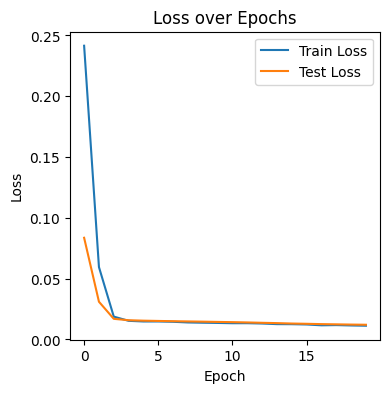

In [5]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [6]:
from ECG_handler import ECGInputHandler
from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(ECGInputHandler, config_path)

# Run the audit 
leakpro.run_audit()

2025-02-18 14:04:09,062 INFO     Target model blueprint created from TimesNet in ./utils/models/TimesNet.py.
2025-02-18 14:04:09,074 INFO     Loaded target model metadata from ./target/model_metadata.pkl
c:\Users\totte\Documents\Kurser\DATX05 - Master's Thesis\LeakPro\leakpro\input_handler\handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start 

{'audit': {'random_seed': 42, 'attack_list': {'ensemble': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_instances': 2, 'subset_size': 50, 'num_pairs': 5}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/TimesNet.py', 'model_class': 'TimesNet', 'target_folder': './target', 'data_path': './data/ECG_E00001.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-02-18 14:04:10,512 INFO     MIA attack factory loaded.
2025-02-18 14:04:10,513 INFO     Creating shadow model handler singleton
2025-02-18 14:04:10,514 INFO     Creating distillation model handler singleton
2025-02-18 14:04:10,516 INFO     Configuring Ensemble attack
2025-02-18 14:04:10,517 INFO     Added attack: ensemble
2025-02-18 14:04:10,518 INFO     Preparing attack: ensemble
2025-02-18 14:04:10,519 INFO     Preparing shadow models for Ensemble attack
2025-02-18 14:04:10,519 INFO     Preparing attack data for training the Ensemble attack
2025-02-18 14:04:10,521 INFO     self.attack_data_indices=array([ 739,  229, 1886, ..., 1366, 1678, 3795])
2025-02-18 14:04:10,522 INFO     Check for 2 shadow models (dataset: 4881 points)
2025-02-18 14:04:10,523 WARNING  Using the same model class for shadow models as the target model.
2025-02-18 14:04:10,528 WARNING  Mismatched model types found in saved shadow models: [(0, 'SimpleLSTM'), (1, 'SimpleLSTM'), (2, 'LSTM'), (3, 'LSTM'), (4, 'TC

KeyboardInterrupt: 

### Testing signals

In [ ]:
from numpy import mean
print(f'Avg train MSE:', mean(train_loss))
print(f'Avg test MSE:', mean(test_loss))

Avg train MSE: 0.018133706142417275
Avg test MSE: 0.013349335078770916


In [10]:
from torch.nn import MSELoss
from leakpro.signals.signal import SeasonalityLoss, TrendLoss
from leakpro.signals.signal_extractor import PytorchModel

pmodel = PytorchModel(model, MSELoss)

seasonality_signal = SeasonalityLoss()
train_sloss = seasonality_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_sloss = seasonality_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

trend_signal = TrendLoss()
train_tloss = trend_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_tloss = trend_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

print(f'Mean train seasonality loss:', mean(train_sloss))
print(f'Mean test seasonality loss:', mean(test_sloss))

print(f'Mean train trend loss:', mean(train_tloss))
print(f'Mean test trend loss:', mean(test_tloss))

Getting seasonality loss for model 1/ 1:   0%|          | 0/90 [00:00<?, ?it/s]

Getting trend loss for model 1/ 1: 100%|██████████| 60/60 [00:00<00:00, 263.55it/s]

Mean train seasonality loss: 17.20105345298603
Mean test seasonality loss: 17.335172387056275
Mean train trend loss: 3.8192964495693715
Mean test trend loss: 4.08500441227763
